# Spleen 3D segmentation with MONAI

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size


## Setup environment

In [1]:
!pip install 'monai[all]'==0.8.0

     |████████████████████████████████| 709 kB 28.2 MB/s eta 0:00:01
     |███████████▊                    | 323.4 MB 128.7 MB/s eta 0:00:05   |█                               | 28.7 MB 28.6 MB/s eta 0:00:30

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████▋               | 459.1 MB 98.3 MB/s eta 0:00:05     |████████████████████████▌       | 675.0 MB 103.6 MB/s eta 0:00:02

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 881.9 MB 87.3 MB/s eta 0:00:01     |████████████████████████████████| 881.9 MB 7.0 kB/s 
     |████████████████████████████████| 232 kB 74.6 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 111.8 MB/s eta 0:00:01
     |████████████████████████████████| 8.5 MB 16.9 MB/s eta 0:00:01     |█████████████████████▏          | 5.6 MB 16.9 MB/s eta 0:00:01
     |████████████████████████████████| 15.6 MB 43.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 49.9 MB/s eta 0:00:01
     |████████████████████████████████| 316 kB 92.6 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 17.9 MB 43.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 49.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 52.8 MB/s eta 0:00:01
     |████████████████████████████████| 125 kB 123.0 

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


In [ ]:
import sagemaker as sagemaker
import shutil
import json
import boto3
import os
!pip install monai[all]==0.8.0
!apt update
!pip install ipywidgets
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.transformer import Transformer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

role = get_execution_role()
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket()
account = boto3.client("sts").get_caller_identity()["Account"]

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [ ]:
# Method 1: download tar file from the internet
MONAI_task = "Task09_Spleen"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = os.path.join(os.getcwd(),'MONAI_Spleen' )
# print(root_dir)
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, f"{MONAI_task}.tar")
data_dir = os.path.join(root_dir, MONAI_task)
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)
print(data_dir)

In [184]:
# Method 2: download tar file to your own S3 bucket and retrieve from S3
MONAI_task = "Task09_Spleen"
s3 = boto3.resource('s3')
copy_source = {
      'Bucket': "msd-for-monai",
      'Key': "Task09_Spleen.tar"
    }
prefix = "MONAI_Segmentation"
bucket_cp = s3.Bucket(bucket)
bucket_cp.copy(copy_source, f"{prefix}/{MONAI_task}.tar")

compressedfile = f"s3://{bucket}/{prefix}/{MONAI_task}.tar"
localpath = "."
download_s3 = sagemaker.s3.S3Downloader.download(
    s3_uri=compressedfile,
    local_path=localpath,
    sagemaker_session=sess
)
!tar -xf Task09_Spleen.tar
data_dir=os.path.join(os.getcwd(), MONAI_task )
print(data_dir)

## Set MSD Spleen dataset path

In [77]:
# !pip install monai[all]==0.8.0
from monai.apps import download_and_extract
import os
import glob
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [78]:
len(data_dicts)

41

In [1]:
# !mkdir train/imagesTr
# !mkdir train/labelsTr
for file in train_files:
    image = file['image']
    image_dest = "train/imagesTr"
    label = file['label']
    label_dest = "train/labelsTr"
    shutil.copy(image,image_dest)
    shutil.copy(label,label_dest)

NameError: name 'train_files' is not defined

In [26]:
# !mkdir val/imagesTr
# !mkdir val/labelsTr
for file in val_files:
    image = file['image']
    image_dest = "val/imagesTr"
    label = file['label']
    label_dest = "val/labelsTr"
    shutil.copy(image,image_dest)
    shutil.copy(label,label_dest)

In [27]:
prefix="MONAI-Segmentation"
bucket = sess.default_bucket()
train_to_s3 = sess.upload_data(
    path="train",
    key_prefix=prefix+"/train",
    bucket=bucket 
)
val_to_s3 = sess.upload_data(
    path="val",
    key_prefix=prefix+"/val",
    bucket=bucket 
)

In [ ]:
print(train_to_s3,"\n",val_to_s3)

(Moved to main.py File)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

(Moved to main.py File)

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

## Training using SageMaker

In [191]:
%timeit

# JSON encode hyperparameters
def json_encode_hyperparameters(hyperparameters):
    return {str(k): json.dumps(v) for (k, v) in hyperparameters.items()}
image_name = "monai-training"
ecr_image = f"{account}.dkr.ecr.{region}.amazonaws.com/{image_name}:latest"

train_files=MONAI_task

hyperparameters = json_encode_hyperparameters({"epochs": 1, "train_batch_size": 2, "val_batch_size": 2, "val_interval": 2, "num_workers": 0})

instance_type = "ml.p3.2xlarge"
# instance_type = "ml.p3.2xlarge"

estimator = Estimator(
    role=role,
    train_instance_count=1,
    train_instance_type=instance_type,
    image_uri=ecr_image,
    hyperparameters=hyperparameters,
#     train_instance_type="local",
)

estimator.fit({"training": train_to_s3, 
               "validation": val_to_s3})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2022-04-16 18:29:01 Starting - Starting the training job...ProfilerReport-1650133741: InProgress
...
2022-04-16 18:29:50 Starting - Preparing the instances for training......
2022-04-16 18:31:00 Downloading - Downloading input data
2022-04-16 18:31:00 Training - Downloading the training image..............................
2022-04-16 18:35:55 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-16 18:35:54,674 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-16 18:35:54,701 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-16 18:35:54,708 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-16 18:35:54,781 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "cha

In [122]:
model_output = estimator.latest_training_job.describe()["ModelArtifacts"]["S3ModelArtifacts"]
model_path = "."
model_artifact = sagemaker.s3.S3Downloader.download(
    s3_uri=model_output,
    local_path=model_path,
    sagemaker_session=sess
)
!gunzip model.tar.gz -f
!tar -xf model.tar

In [125]:
model = torch.load(os.path.join(model_path, "best_metric_model.pth"))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


## Inference on Test Set

In [135]:
test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

In [143]:
device = torch.device("cpu")
with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

file written: /home/ec2-user/SageMaker/AmazonSageMaker-SageMaker-DL1/Segmentation/out/spleen_1/spleen_1_seg.nii.gz.
file written: /home/ec2-user/SageMaker/AmazonSageMaker-SageMaker-DL1/Segmentation/out/spleen_11/spleen_11_seg.nii.gz.
file written: /home/ec2-user/SageMaker/AmazonSageMaker-SageMaker-DL1/Segmentation/out/spleen_15/spleen_15_seg.nii.gz.
file written: /home/ec2-user/SageMaker/AmazonSageMaker-SageMaker-DL1/Segmentation/out/spleen_23/spleen_23_seg.nii.gz.
file written: /home/ec2-user/SageMaker/AmazonSageMaker-SageMaker-DL1/Segmentation/out/spleen_30/spleen_30_seg.nii.gz.
file written: /home/ec2-user/SageMaker/AmazonSageMaker-SageMaker-DL1/Segmentation/out/spleen_34/spleen_34_seg.nii.gz.
file written: /home/ec2-user/SageMaker/AmazonSageMaker-SageMaker-DL1/Segmentation/out/spleen_35/spleen_35_seg.nii.gz.
file written: /home/ec2-user/SageMaker/AmazonSageMaker-SageMaker-DL1/Segmentation/out/spleen_36/spleen_36_seg.nii.gz.
file written: /home/ec2-user/SageMaker/AmazonSageMaker-Sag

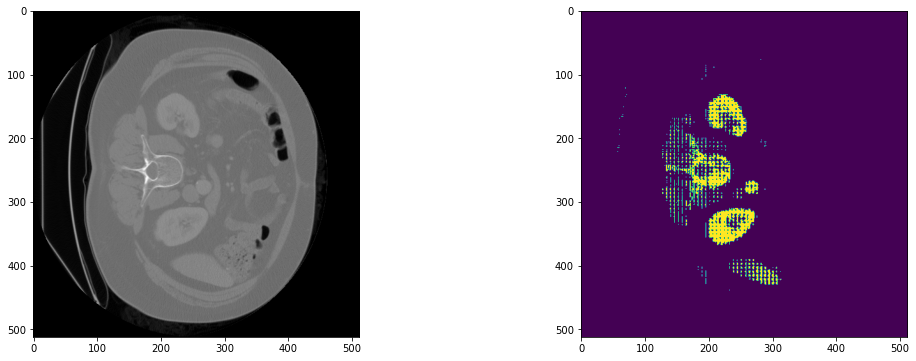

In [158]:
# uncomment the following lines to visualize the predicted results
from monai.handlers.utils import from_engine
from monai.transforms import LoadImage
loader = LoadImage()

test_output = from_engine(["pred"])(test_data)

original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

plt.figure("check", (18, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image[:, :, 20], cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
plt.show()

In [157]:
# upload the file to S3
# transform_input = sess.upload_data(test_org_loader, key_prefix="MONAI-spleen-model")
# print("Transform input uploaded to " + transform_input)

In [121]:
# estimator.transformer(instance_count=1, instance_type="ml.p3.2xlarge")
# model_sm = sess.create_model_from_job(
#     estimator._current_job_name, name="{}-test".format(estimator._current_job_name)
# )

In [ ]:
# model_sm.transform(train_s3, content_type="text/csv", split_type="Line")
# model_sm.wait()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)